# Prelim exploration

In [155]:
from __future__ import annotations

from pathlib import Path
import re
from functools import lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Folder is next to the notebook:
DATASET_DIR = Path("dataset")

# DDF datapoints filename convention you showed:
GLOB_PATTERN = "ddf--datapoints--*--by--geo--time.csv"
FILENAME_RX = re.compile(r"^ddf--datapoints--(.+)--by--geo--time\.csv$")


In [156]:
files = sorted(DATASET_DIR.glob(GLOB_PATTERN))

catalog_rows = []
for f in files:
    m = FILENAME_RX.match(f.name)
    if not m:
        continue
    indicator = m.group(1)
    catalog_rows.append({"indicator": indicator, "path": f, "filename": f.name})

catalog = pd.DataFrame(catalog_rows).sort_values("indicator").reset_index(drop=True)

print(f"Found {len(catalog)} datapoints files in {DATASET_DIR.resolve()}")
catalog.head(10)


Found 30 datapoints files in C:\Users\hugok\OneDrive\Dokumenty\GitHub\WellBeingVisualisation\dataset


indicator  \
0  alcohol_consumption_per_adult_15plus_litres   
1              body_mass_index_bmi_men_kgperm2   
2            body_mass_index_bmi_women_kgperm2   
3        breast_cancer_deaths_per_100000_women   
4                   cell_phones_per_100_people   
5                            cell_phones_total   
6        cholesterol_fat_in_blood_men_mmolperl   
7      cholesterol_fat_in_blood_women_mmolperl   
8               data_quality_income_per_person   
9       economic_growth_over_the_past_10_years   

                                                path  \
0  dataset\ddf--datapoints--alcohol_consumption_p...   
1  dataset\ddf--datapoints--body_mass_index_bmi_m...   
2  dataset\ddf--datapoints--body_mass_index_bmi_w...   
3  dataset\ddf--datapoints--breast_cancer_deaths_...   
4  dataset\ddf--datapoints--cell_phones_per_100_p...   
5  dataset\ddf--datapoints--cell_phones_total--by...   
6  dataset\ddf--datapoints--cholesterol_fat_in_bl...   
7  dataset\ddf--datapoints--cholesterol_fat_in_bl...   
8  dataset\ddf--datapoints--data_quality_income_p...   
9  dataset\ddf--datapoints--economic_growth_over_...   

                                            filename  
0  ddf--datapoints--alcohol_consumption_per_adult...  
1  ddf--datapoints--body_mass_index_bmi_men_kgper...  
2  ddf--datapoints--body_mass_index_bmi_women_kgp...  
3  ddf--datapoints--breast_cancer_deaths_per_1000...  
4  ddf--datapoints--cell_phones_per_100_people--b...  
5  ddf--datapoints--cell_phones_total--by--geo--t...  
6  ddf--datapoints--cholesterol_fat_in_blood_men_...  
7  ddf--datapoints--cholesterol_fat_in_blood_wome...  
8  ddf--datapoints--data_quality_income_per_perso...  
9  ddf--datapoints--economic_growth_over_the_past...

In [157]:
def _read_csv(path: Path) -> pd.DataFrame:
    # Keep as strings first, then convert selectively
    return pd.read_csv(path)

@lru_cache(maxsize=512)
def load_indicator(indicator: str) -> pd.DataFrame:
    row = catalog.loc[catalog["indicator"].eq(indicator)]
    if row.empty:
        raise KeyError(f"Unknown indicator: {indicator}")

    path = Path(row.iloc[0]["path"])
    df = _read_csv(path)

    # Validate expected columns
    expected = {"geo", "time", indicator}
    missing = expected - set(df.columns)
    if missing:
        raise ValueError(f"{path.name} is missing columns: {missing}. Has: {list(df.columns)}")

    # Normalize schema
    out = df.rename(columns={indicator: "value"}).copy()
    out["indicator"] = indicator

    # Types
    out["geo"] = out["geo"].astype(str)
    out["time"] = pd.to_numeric(out["time"], errors="coerce").astype("Int64")

    # Value -> numeric when possible; keep non-numeric as object if needed
    # (Many Gapminder datapoints are numeric; this gives you numeric plots easily.)
    out["value"] = pd.to_numeric(out["value"], errors="coerce")

    return out[["indicator", "geo", "time", "value"]]


In [158]:
def describe_indicator(indicator: str) -> dict:
    df = load_indicator(indicator)
    return {
        "indicator": indicator,
        "rows": int(len(df)),
        "geos": int(df["geo"].nunique()),
        "time_min": int(df["time"].min()) if df["time"].notna().any() else None,
        "time_max": int(df["time"].max()) if df["time"].notna().any() else None,
        "missing_values": int(df["value"].isna().sum()),
    }

summary = pd.DataFrame([describe_indicator(ind) for ind in catalog["indicator"]])
summary.sort_values(["rows"], ascending=False).reset_index(drop=True).head(20)


indicator   rows  geos  time_min  \
0                 data_quality_income_per_person  18778   229      1700   
1                              cell_phones_total  10374   212      1960   
2                     cell_phones_per_100_people  10350   212      1960   
3          breast_cancer_deaths_per_100000_women   8976   204      1980   
4                           suicide_total_deaths   8976   204      1980   
5              body_mass_index_bmi_women_kgperm2   8022   191      1975   
6                body_mass_index_bmi_men_kgperm2   8022   191      1975   
7          cholesterol_fat_in_blood_men_mmolperl   7449   191      1980   
8        cholesterol_fat_in_blood_women_mmolperl   7449   191      1980   
9         economic_growth_over_the_past_10_years   5492   180      1960   
10               suicide_women_per_100000_people   4070   185      2000   
11                     suicide_per_100000_people   4070   185      2000   
12                 suicide_men_per_100000_people   4070   185      2000   
13  females_aged_15_24_unemployment_rate_percent   3392   213      1948   
14  females_aged_25_54_unemployment_rate_percent   3369   213      1948   
15                        working_hours_per_week   2511   179      1969   
16      male_long_term_unemployment_rate_percent   2206   153      1990   
17           total_number_of_dollar_billionaires   1651    90      1997   
18   alcohol_consumption_per_adult_15plus_litres    409   188      1985   
19           suicide_age_45_54_per_100000_people    183   183      2019   

    time_max  missing_values  
0       2012               0  
1       2023               0  
2       2023               0  
3       2023               0  
4       2023               0  
5       2016               0  
6       2016               0  
7       2018               0  
8       2018               0  
9       2004               0  
10      2021               0  
11      2021               0  
12      2021               0  
13      2025               0  
14      2025               0  
15      2025               0  
16      2025               0  
17      2025               0  
18      2008               0  
19      2019               0

In [159]:
def find_indicators(keyword: str, case: bool = False) -> pd.DataFrame:
    mask = catalog["indicator"].str.contains(keyword, case=case, regex=False)
    return catalog.loc[mask, ["indicator", "filename"]].reset_index(drop=True)

# examples:
find_indicators("suicide").head(30)


indicator  \
0    suicide_age_15_19_per_100000_people   
1    suicide_age_15_24_per_100000_people   
2    suicide_age_15_29_per_100000_people   
3    suicide_age_25_34_per_100000_people   
4    suicide_age_30_49_per_100000_people   
5    suicide_age_35_44_per_100000_people   
6    suicide_age_45_54_per_100000_people   
7    suicide_age_55_64_per_100000_people   
8    suicide_age_65_74_per_100000_people   
9    suicide_age_75_84_per_100000_people   
10  suicide_age_85plus_per_100000_people   
11         suicide_men_per_100000_people   
12             suicide_per_100000_people   
13                  suicide_total_deaths   
14       suicide_women_per_100000_people   

                                             filename  
0   ddf--datapoints--suicide_age_15_19_per_100000_...  
1   ddf--datapoints--suicide_age_15_24_per_100000_...  
2   ddf--datapoints--suicide_age_15_29_per_100000_...  
3   ddf--datapoints--suicide_age_25_34_per_100000_...  
4   ddf--datapoints--suicide_age_30_49_per_100000_...  
5   ddf--datapoints--suicide_age_35_44_per_100000_...  
6   ddf--datapoints--suicide_age_45_54_per_100000_...  
7   ddf--datapoints--suicide_age_55_64_per_100000_...  
8   ddf--datapoints--suicide_age_65_74_per_100000_...  
9   ddf--datapoints--suicide_age_75_84_per_100000_...  
10  ddf--datapoints--suicide_age_85plus_per_100000...  
11  ddf--datapoints--suicide_men_per_100000_people...  
12  ddf--datapoints--suicide_per_100000_people--by...  
13  ddf--datapoints--suicide_total_deaths--by--geo...  
14  ddf--datapoints--suicide_women_per_100000_peop...

In [160]:
def coverage(indicator: str) -> dict:
    df = load_indicator(indicator)
    return {
        "indicator": indicator,
        "n_geos": int(df["geo"].nunique()),
        "geos_sample": sorted(df["geo"].unique())[:25],
        "time_min": int(df["time"].min()) if df["time"].notna().any() else None,
        "time_max": int(df["time"].max()) if df["time"].notna().any() else None,
    }

# pick one:
coverage(catalog["indicator"].iloc[0])


{'indicator': 'alcohol_consumption_per_adult_15plus_litres',
 'n_geos': 188,
 'geos_sample': ['afg',
  'ago',
  'alb',
  'and',
  'are',
  'arg',
  'arm',
  'atg',
  'aus',
  'aut',
  'aze',
  'bdi',
  'bel',
  'ben',
  'bfa',
  'bgd',
  'bgr',
  'bhr',
  'bhs',
  'bih',
  'blr',
  'blz',
  'bol',
  'bra',
  'brb'],
 'time_min': 1985,
 'time_max': 2008}

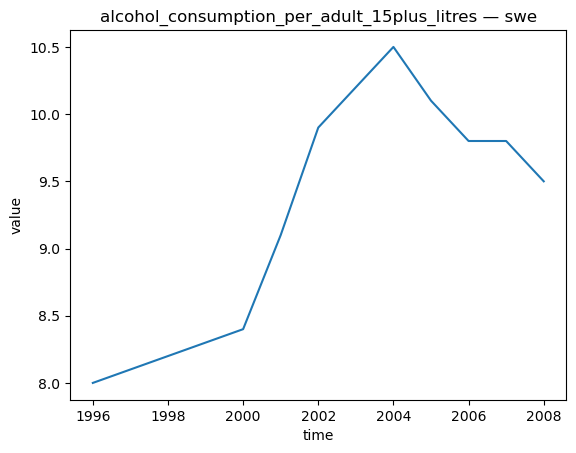

In [161]:
def timeseries(indicator: str, geo: str) -> pd.DataFrame:
    df = load_indicator(indicator)
    out = df[df["geo"].eq(geo)].dropna(subset=["time"]).sort_values("time").reset_index(drop=True)
    return out

def plot_timeseries(indicator: str, geo: str):
    ts = timeseries(indicator, geo)
    if ts.empty:
        print(f"No data for geo={geo!r} in indicator={indicator!r}")
        return
    plt.figure()
    plt.plot(ts["time"].astype(float), ts["value"])
    plt.title(f"{indicator} — {geo}")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.show()

# Example (change geo to something you have, e.g. 'swe', 'usa', 'esp', etc.)
plot_timeseries(catalog["indicator"].iloc[0], "swe")


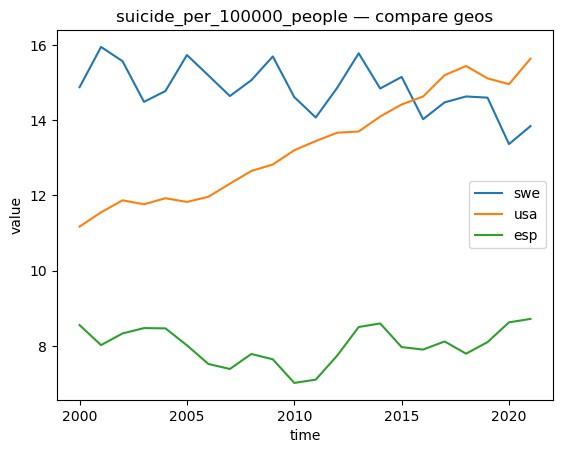

In [162]:
def plot_compare_geos(indicator: str, geos: list[str]):
    df = load_indicator(indicator).dropna(subset=["time"]).sort_values("time")
    plt.figure()
    for g in geos:
        ts = df[df["geo"].eq(g)]
        if ts.empty:
            continue
        plt.plot(ts["time"].astype(float), ts["value"], label=g)
    plt.title(f"{indicator} — compare geos")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.legend()
    plt.show()

plot_compare_geos("suicide_per_100000_people", ["swe", "usa", "esp"])


In [163]:
def snapshot(geo: str, time: int) -> pd.DataFrame:
    rows = []
    for ind in catalog["indicator"]:
        df = load_indicator(ind)
        v = df.loc[(df["geo"].eq(geo)) & (df["time"].eq(time)), "value"]
        if not v.empty:
            rows.append({"indicator": ind, "value": float(v.iloc[0]) if pd.notna(v.iloc[0]) else np.nan})
    out = pd.DataFrame(rows).dropna(subset=["value"]).sort_values("indicator").reset_index(drop=True)
    return out

snapshot("swe", 2019).head(30)


indicator         value
0          breast_cancer_deaths_per_100000_women  1.490000e+01
1                     cell_phones_per_100_people  1.254570e+02
2                              cell_phones_total  1.289590e+07
3   females_aged_15_24_unemployment_rate_percent  1.970200e+01
4   females_aged_25_54_unemployment_rate_percent  5.646000e+00
5       male_long_term_unemployment_rate_percent  1.237160e+00
6            suicide_age_15_19_per_100000_people  7.110000e+00
7            suicide_age_15_24_per_100000_people  1.098000e+01
8            suicide_age_15_29_per_100000_people  1.457000e+01
9            suicide_age_25_34_per_100000_people  1.948000e+01
10           suicide_age_30_49_per_100000_people  1.690000e+01
11           suicide_age_35_44_per_100000_people  1.612000e+01
12           suicide_age_45_54_per_100000_people  1.797000e+01
13           suicide_age_55_64_per_100000_people  1.986000e+01
14           suicide_age_65_74_per_100000_people  1.630000e+01
15           suicide_age_75_84_per_100000_people  1.909000e+01
16          suicide_age_85plus_per_100000_people  2.437000e+01
17                 suicide_men_per_100000_people  1.933679e+01
18                     suicide_per_100000_people  1.459669e+01
19                          suicide_total_deaths  1.485610e+03
20               suicide_women_per_100000_people  9.801530e+00
21           total_number_of_dollar_billionaires  3.400000e+01
22                        working_hours_per_week  3.494000e+01

In [164]:
all_long = pd.concat([load_indicator(ind) for ind in catalog["indicator"]], ignore_index=True)
all_long.head(), all_long.shape


(                                     indicator  geo  time  value
 0  alcohol_consumption_per_adult_15plus_litres  afg  2005   0.02
 1  alcohol_consumption_per_adult_15plus_litres  afg  2008   0.03
 2  alcohol_consumption_per_adult_15plus_litres  ago  2005   5.40
 3  alcohol_consumption_per_adult_15plus_litres  ago  2008   5.57
 4  alcohol_consumption_per_adult_15plus_litres  alb  2005   6.68,
 (121649, 4))

In [165]:
OUT_PARQUET = Path("all_datapoints_long.parquet")
all_long.to_parquet(OUT_PARQUET, index=False)
print("Wrote:", OUT_PARQUET.resolve())


Wrote: C:\Users\hugok\OneDrive\Dokumenty\GitHub\WellBeingVisualisation\all_datapoints_long.parquet


In [166]:
all_long = pd.read_parquet("all_datapoints_long.parquet")
all_long.shape


(121649, 4)

In [167]:
wide = all_long.pivot_table(
    index=["geo", "time"],
    columns="indicator",
    values="value",
    aggfunc="first"
).reset_index()

wide.head()


indicator  geo  time  alcohol_consumption_per_adult_15plus_litres  \
0          abw  1700                                          NaN   
1          abw  1800                                          NaN   
2          abw  1899                                          NaN   
3          abw  1900                                          NaN   
4          abw  1935                                          NaN   

indicator  body_mass_index_bmi_men_kgperm2  body_mass_index_bmi_women_kgperm2  \
0                                      NaN                                NaN   
1                                      NaN                                NaN   
2                                      NaN                                NaN   
3                                      NaN                                NaN   
4                                      NaN                                NaN   

indicator  breast_cancer_deaths_per_100000_women  cell_phones_per_100_people  \
0                                            NaN                         NaN   
1                                            NaN                         NaN   
2                                            NaN                         NaN   
3                                            NaN                         NaN   
4                                            NaN                         NaN   

indicator  cell_phones_total  cholesterol_fat_in_blood_men_mmolperl  \
0                        NaN                                    NaN   
1                        NaN                                    NaN   
2                        NaN                                    NaN   
3                        NaN                                    NaN   
4                        NaN                                    NaN   

indicator  cholesterol_fat_in_blood_women_mmolperl  ...  \
0                                              NaN  ...   
1                                              NaN  ...   
2                                              NaN  ...   
3                                              NaN  ...   
4                                              NaN  ...   

indicator  suicide_age_55_64_per_100000_people  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

indicator  suicide_age_65_74_per_100000_people  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

indicator  suicide_age_75_84_per_100000_people  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

indicator  suicide_age_85plus_per_100000_people  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

indicator  suicide_men_per_100000_people  suicide_per_100000_people  \
0                                    NaN                        NaN   
1                                    NaN                        NaN   
2                                    NaN                        NaN   
3                                    NaN                        NaN   
4                                    NaN                        NaN   

indicator  suicide_total_deaths  suicide_women_per_100000_people  \
0                           NaN                              NaN   
1                           NaN                              N

In [168]:
missing_by_indicator = (
    all_long.assign(is_missing=lambda d: d["value"].isna())
            .groupby("indicator", as_index=False)
            .agg(rows=("value", "size"), missing=("is_missing", "sum"))
            .assign(missing_pct=lambda d: d["missing"] / d["rows"])
            .sort_values("missing_pct", ascending=False)
            .reset_index(drop=True)
)

missing_by_indicator.head(20)


indicator  rows  missing  missing_pct
0    alcohol_consumption_per_adult_15plus_litres   409        0          0.0
1                body_mass_index_bmi_men_kgperm2  8022        0          0.0
2            total_number_of_dollar_billionaires  1651        0          0.0
3                suicide_women_per_100000_people  4070        0          0.0
4                           suicide_total_deaths  8976        0          0.0
5                      suicide_per_100000_people  4070        0          0.0
6                  suicide_men_per_100000_people  4070        0          0.0
7           suicide_age_85plus_per_100000_people   183        0          0.0
8            suicide_age_75_84_per_100000_people   183        0          0.0
9            suicide_age_65_74_per_100000_people   183        0          0.0
10           suicide_age_55_64_per_100000_people   183        0          0.0
11           suicide_age_45_54_per_100000_people   183        0          0.0
12           suicide_age_35_44_per_100000_people   183        0          0.0
13           suicide_age_30_49_per_100000_people   183        0          0.0
14           suicide_age_25_34_per_100000_people   183        0          0.0
15           suicide_age_15_29_per_100000_people   183        0          0.0
16           suicide_age_15_24_per_100000_people   183        0          0.0
17           suicide_age_15_19_per_100000_people   183        0          0.0
18      male_long_term_unemployment_rate_percent  2206        0          0.0
19  females_aged_25_54_unemployment_rate_percent  3369        0          0.0

In [169]:
coverage_rank = summary.assign(
    time_span=lambda d: (d["time_max"] - d["time_min"])
).sort_values(["geos", "time_span", "rows"], ascending=False).reset_index(drop=True)

coverage_rank.head(20)


indicator   rows  geos  time_min  \
0                 data_quality_income_per_person  18778   229      1700   
1   females_aged_15_24_unemployment_rate_percent   3392   213      1948   
2   females_aged_25_54_unemployment_rate_percent   3369   213      1948   
3                              cell_phones_total  10374   212      1960   
4                     cell_phones_per_100_people  10350   212      1960   
5          breast_cancer_deaths_per_100000_women   8976   204      1980   
6                           suicide_total_deaths   8976   204      1980   
7                body_mass_index_bmi_men_kgperm2   8022   191      1975   
8              body_mass_index_bmi_women_kgperm2   8022   191      1975   
9          cholesterol_fat_in_blood_men_mmolperl   7449   191      1980   
10       cholesterol_fat_in_blood_women_mmolperl   7449   191      1980   
11   alcohol_consumption_per_adult_15plus_litres    409   188      1985   
12                 suicide_men_per_100000_people   4070   185      2000   
13                     suicide_per_100000_people   4070   185      2000   
14               suicide_women_per_100000_people   4070   185      2000   
15           suicide_age_15_19_per_100000_people    183   183      2019   
16           suicide_age_15_24_per_100000_people    183   183      2019   
17           suicide_age_15_29_per_100000_people    183   183      2019   
18           suicide_age_25_34_per_100000_people    183   183      2019   
19           suicide_age_30_49_per_100000_people    183   183      2019   

    time_max  missing_values  time_span  
0       2012               0        312  
1       2025               0         77  
2       2025               0         77  
3       2023               0         63  
4       2023               0         63  
5       2023               0         43  
6       2023               0         43  
7       2016               0         41  
8       2016               0         41  
9       2018               0         38  
10      2018               0         38  
11      2008               0         23  
12      2021               0         21  
13      2021               0         21  
14      2021               0         21  
15      2019               0          0  
16      2019               0          0  
17      2019               0          0  
18      2019               0          0  
19      2019               0          0

# Graphs

In [170]:
from pathlib import Path
import re
from functools import lru_cache

import pandas as pd
import matplotlib.pyplot as plt

DATASET_DIR = Path("dataset")
RX = re.compile(r"^ddf--datapoints--(.+)--by--geo--time\.csv$")


In [171]:
files = DATASET_DIR.glob("ddf--datapoints--*--by--geo--time.csv")

catalog = {}
for f in files:
    m = RX.match(f.name)
    if m:
        catalog[m.group(1)] = f

@lru_cache(maxsize=512)
def load(indicator: str) -> pd.DataFrame:
    df = pd.read_csv(catalog[indicator])
    df = df.rename(columns={indicator: "value"})
    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    return df[["geo", "time", "value"]].dropna(subset=["time"])


In [172]:
def plot_timeseries(indicator, geos=("usa", "swe", "deu", "fra", "jpn")):
    df = load(indicator)
    plt.figure()
    for g in geos:
        d = df[df.geo == g]
        if not d.empty:
            plt.plot(d.time, d.value, label=g)
    plt.title(indicator.replace("_", " "))
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


def plot_latest_bar(indicator, year=None, top_n=15):
    df = load(indicator)
    if year is None:
        year = int(df.time.max())
    d = df[df.time == year].dropna().sort_values("value", ascending=False).head(top_n)

    plt.figure()
    plt.barh(d.geo, d.value)
    plt.title(f"{indicator.replace('_', ' ')} ({year})")
    plt.xlabel("Value")
    plt.gca().invert_yaxis()
    plt.show()


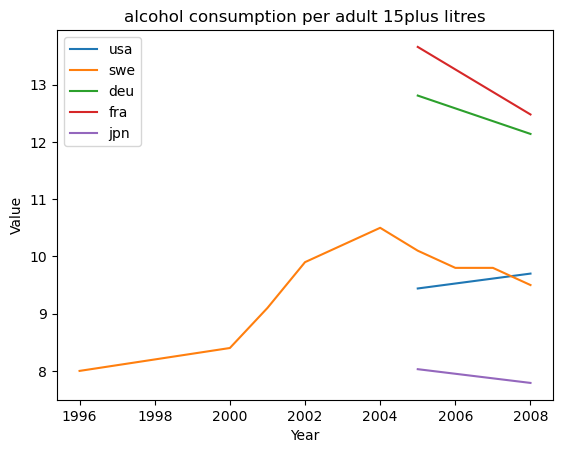

In [173]:
plot_timeseries("alcohol_consumption_per_adult_15plus_litres")

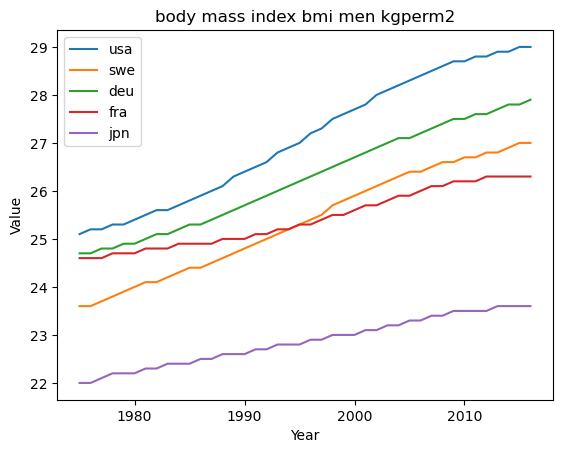

In [174]:
plot_timeseries("body_mass_index_bmi_men_kgperm2")

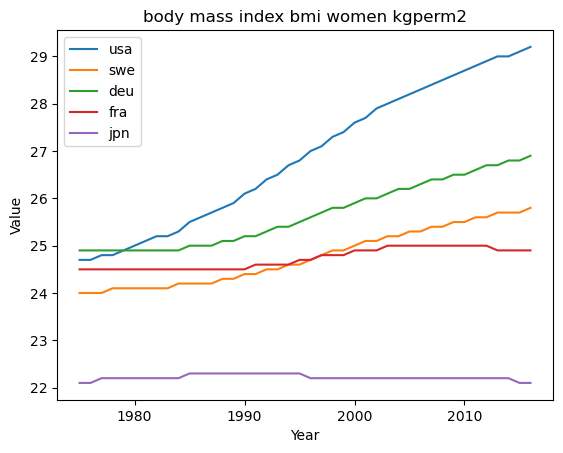

In [175]:
plot_timeseries("body_mass_index_bmi_women_kgperm2")

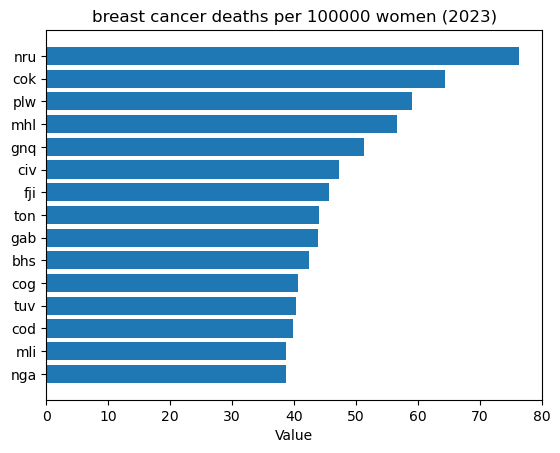

In [176]:
plot_latest_bar("breast_cancer_deaths_per_100000_women")

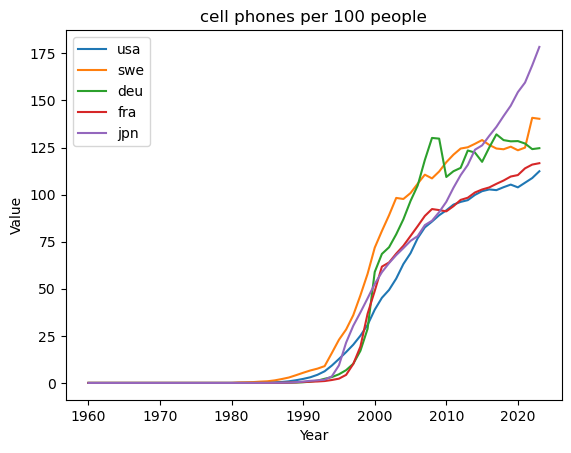

In [177]:
plot_timeseries("cell_phones_per_100_people")


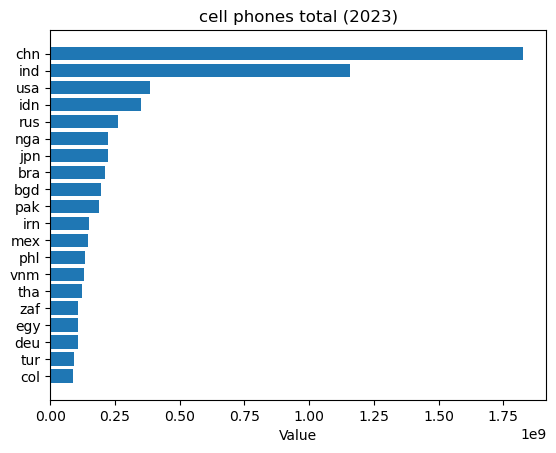

In [178]:
plot_latest_bar("cell_phones_total", top_n=20)


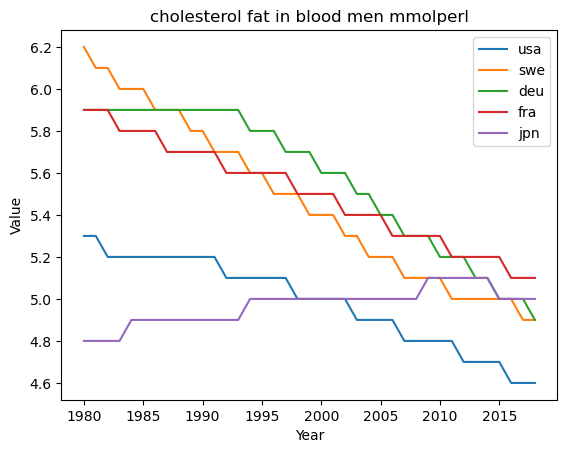

In [179]:
plot_timeseries("cholesterol_fat_in_blood_men_mmolperl")


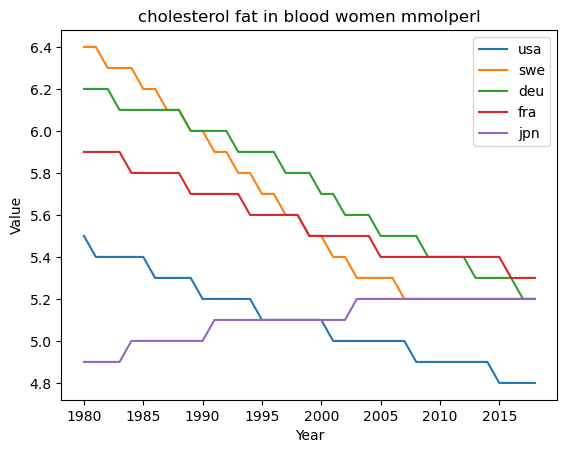

In [180]:
plot_timeseries("cholesterol_fat_in_blood_women_mmolperl")


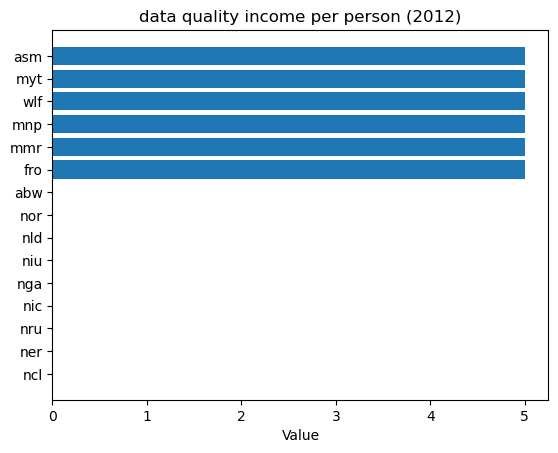

In [181]:
plot_latest_bar("data_quality_income_per_person")


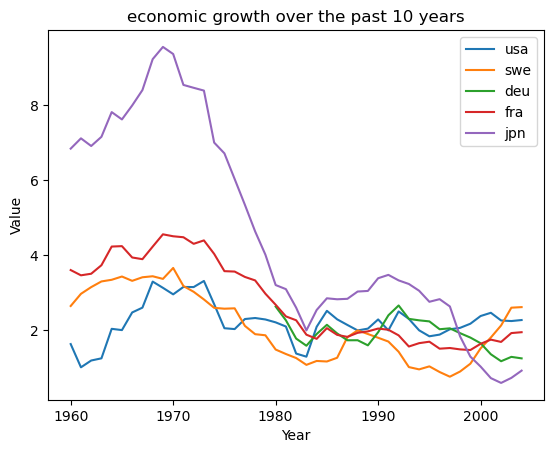

In [182]:
plot_timeseries("economic_growth_over_the_past_10_years")


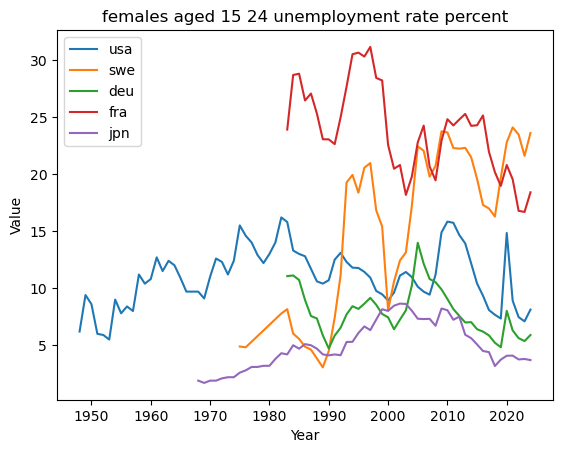

In [183]:
plot_timeseries("females_aged_15_24_unemployment_rate_percent")


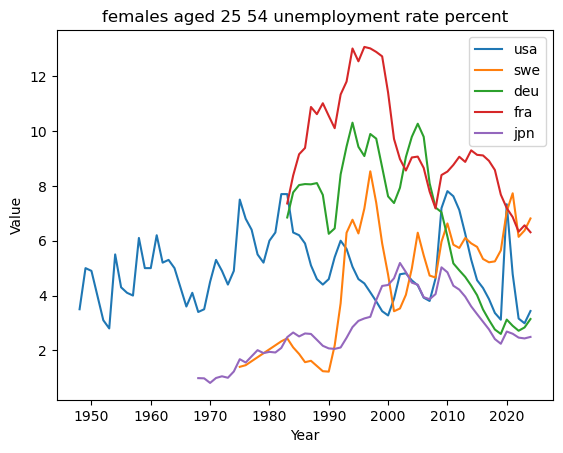

In [184]:
plot_timeseries("females_aged_25_54_unemployment_rate_percent")


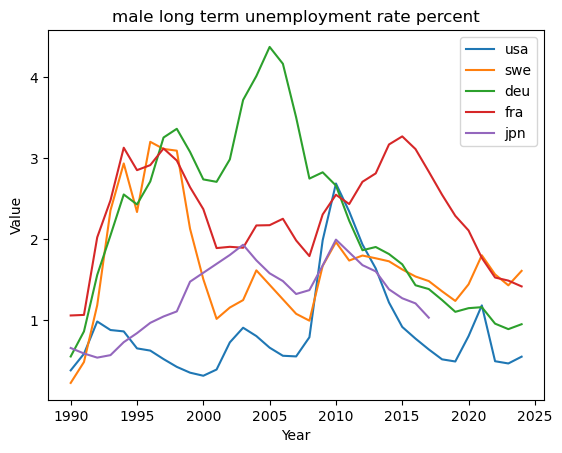

In [185]:
plot_timeseries("male_long_term_unemployment_rate_percent")


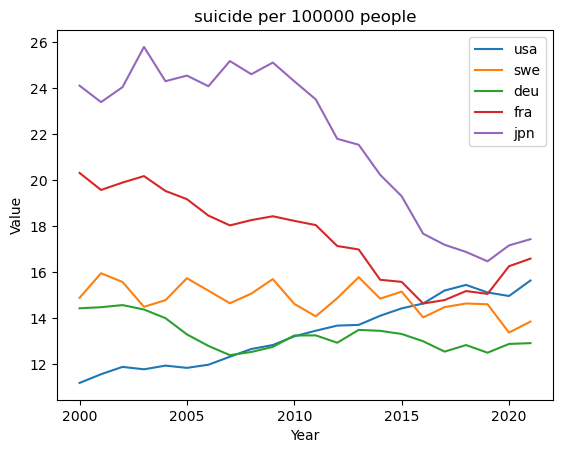

In [186]:
plot_timeseries("suicide_per_100000_people")


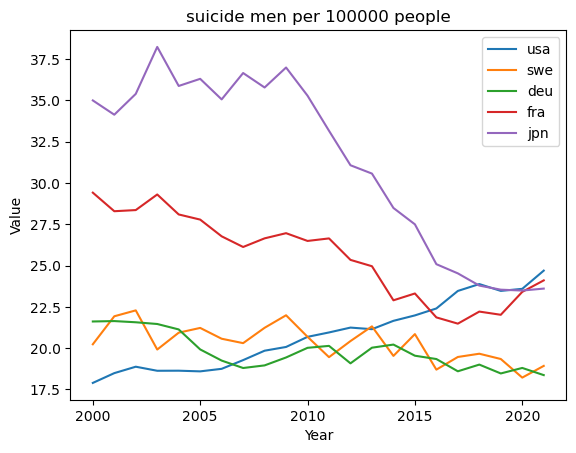

In [187]:
plot_timeseries("suicide_men_per_100000_people")

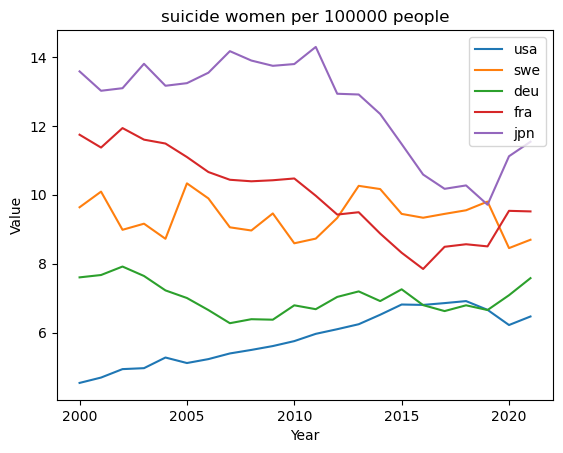

In [188]:
plot_timeseries("suicide_women_per_100000_people")

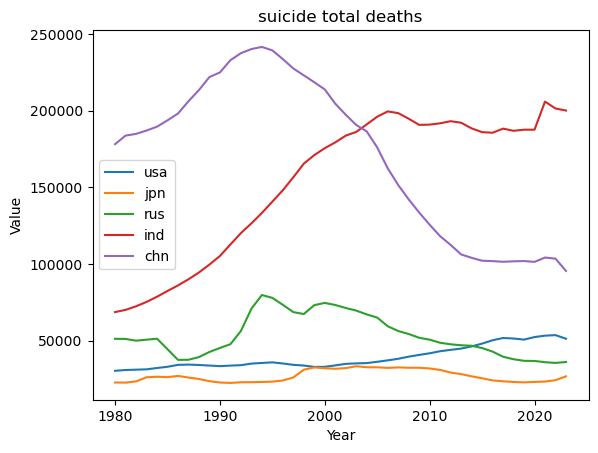

In [189]:
plot_timeseries("suicide_total_deaths", geos=("usa", "jpn", "rus", "ind", "chn"))


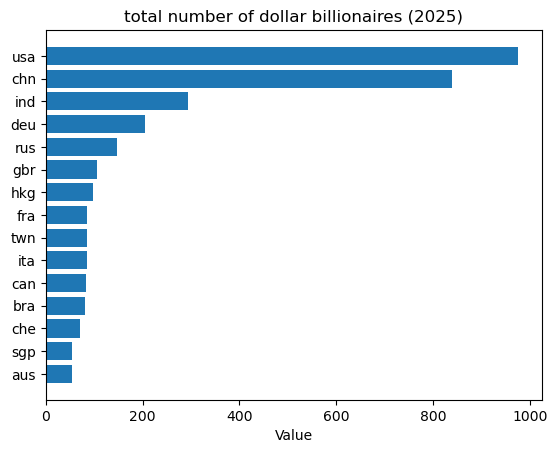

In [190]:
plot_latest_bar("total_number_of_dollar_billionaires")


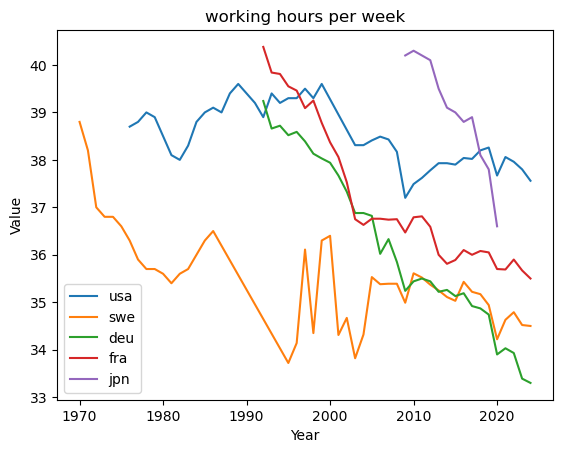

In [191]:
plot_timeseries("working_hours_per_week")


# Heat Maps

In [192]:
!pip install plotly


In [193]:
import plotly.express as px
import pandas as pd


In [194]:
import plotly.io as pio

# If you're in VS Code notebooks, this is usually the right one:
pio.renderers.default = "vscode"

# If you're in classic Jupyter Notebook / JupyterLab and vscode doesn't work, try:
# pio.renderers.default = "notebook_connected"
# or:
# pio.renderers.default = "jupyterlab"


In [195]:
import pandas as pd
import plotly.express as px

test = pd.DataFrame({
    "iso3": ["AFG", "SWE", "USA", "ESP", "CHN"],
    "value": [2, 10, 8, 6, 4]
})

fig = px.choropleth(
    test,
    locations="iso3",
    locationmode="ISO-3",
    color="value",
    title="Renderer test map"
)
fig.show()


In [196]:
import plotly.express as px

def plot_world_map(indicator: str, year: int | None = None):
    df = load(indicator).copy()

    # IMPORTANT: Plotly expects ISO-3 uppercase
    df["iso3"] = df["geo"].astype(str).str.upper()

    if year is None:
        year = int(df["time"].max())

    d = df[df["time"] == year].dropna(subset=["value", "iso3"])

    print(f"{indicator} | year={year} | rows={len(d)} | unique ISO3={d['iso3'].nunique()}")

    fig = px.choropleth(
        d,
        locations="iso3",
        locationmode="ISO-3",
        color="value",
        hover_name="iso3",
        hover_data={"value": True},
        title=f"{indicator.replace('_', ' ')} ({year})",
        color_continuous_scale="Viridis",
    )

    fig.update_layout(margin=dict(l=0, r=0, t=40, b=0))
    fig.show()


In [197]:
plot_world_map("suicide_women_per_100000_people")


suicide_women_per_100000_people | year=2021 | rows=185 | unique ISO3=185


In [198]:
def plot_world_map_animated(indicator: str):
    df = load(indicator).copy()
    df["iso3"] = df["geo"].astype(str).str.upper()

    df = df.dropna(subset=["value", "iso3", "time"])

    fig = px.choropleth(
        df,
        locations="iso3",
        locationmode="ISO-3",
        color="value",
        animation_frame="time",
        color_continuous_scale="Viridis",
        title=indicator.replace("_", " "),
    )

    fig.update_layout(margin=dict(l=0, r=0, t=40, b=0))
    fig.show()


In [199]:
plot_world_map_animated("suicide_women_per_100000_people")


In [200]:
plot_world_map_animated("alcohol_consumption_per_adult_15plus_litres")


In [201]:
plot_world_map_animated("body_mass_index_bmi_men_kgperm2")


In [202]:
plot_world_map_animated("body_mass_index_bmi_women_kgperm2")


In [203]:
plot_world_map_animated("breast_cancer_deaths_per_100000_women")


In [204]:
plot_world_map_animated("cell_phones_per_100_people")


In [205]:
plot_world_map_animated("cell_phones_total")


In [206]:
plot_world_map_animated("cholesterol_fat_in_blood_men_mmolperl")


In [207]:
plot_world_map_animated("cholesterol_fat_in_blood_women_mmolperl")


In [208]:
plot_world_map_animated("data_quality_income_per_person")


In [209]:
plot_world_map_animated("economic_growth_over_the_past_10_years")


In [210]:
plot_world_map_animated("females_aged_15_24_unemployment_rate_percent")


In [211]:
plot_world_map_animated("females_aged_25_54_unemployment_rate_percent")


In [212]:
plot_world_map_animated("male_long_term_unemployment_rate_percent")


In [213]:
plot_world_map_animated("suicide_age_15_19_per_100000_people")


In [214]:
plot_world_map_animated("suicide_age_15_24_per_100000_people")


In [215]:
plot_world_map_animated("suicide_age_15_29_per_100000_people")


In [216]:
plot_world_map_animated("suicide_age_25_34_per_100000_people")


In [217]:
plot_world_map_animated("suicide_age_35_44_per_100000_people")


In [218]:
plot_world_map_animated("suicide_age_45_54_per_100000_people")


In [219]:
plot_world_map_animated("suicide_age_55_64_per_100000_people")


In [220]:
plot_world_map_animated("suicide_age_65_74_per_100000_people")


In [221]:
plot_world_map_animated("suicide_age_75_84_per_100000_people")


In [222]:
plot_world_map_animated("suicide_age_85plus_per_100000_people")


In [223]:
plot_world_map_animated("suicide_men_per_100000_people")


In [224]:
plot_world_map_animated("suicide_per_100000_people")


In [225]:
plot_world_map_animated("suicide_total_deaths")


In [226]:
plot_world_map_animated("suicide_women_per_100000_people")


In [227]:
plot_world_map_animated("total_number_of_dollar_billionaires")


In [228]:
plot_world_map_animated("working_hours_per_week")


# Further statistics


In [229]:
import pandas as pd

def suicides_yoy_percent(geos=("usa","jpn","rus","ind","chn"), start_year=None, end_year=None):
    df = load("suicide_total_deaths").copy()

    # filter geos + time range
    df = df[df["geo"].isin(geos)]
    if start_year is not None:
        df = df[df["time"] >= start_year]
    if end_year is not None:
        df = df[df["time"] <= end_year]

    df = df.sort_values(["geo", "time"])

    # YoY percent change: (this_year - last_year) / last_year * 100
    df["yoy_pct"] = df.groupby("geo")["value"].pct_change() * 100

    return df

yoy = suicides_yoy_percent(geos=("usa","jpn","rus","ind","chn"))
yoy.head(12)


geo  time      value   yoy_pct
1496  chn  1980  178139.60       NaN
1497  chn  1981  183713.26  3.128816
1498  chn  1982  184825.02  0.605160
1499  chn  1983  187004.06  1.178975
1500  chn  1984  189532.25  1.351944
1501  chn  1985  193665.25  2.180632
1502  chn  1986  198111.93  2.296065
1503  chn  1987  206096.89  4.030530
1504  chn  1988  213404.62  3.545774
1505  chn  1989  221933.00  3.996343
1506  chn  1990  224893.77  1.334083
1507  chn  1991  232886.63  3.554060

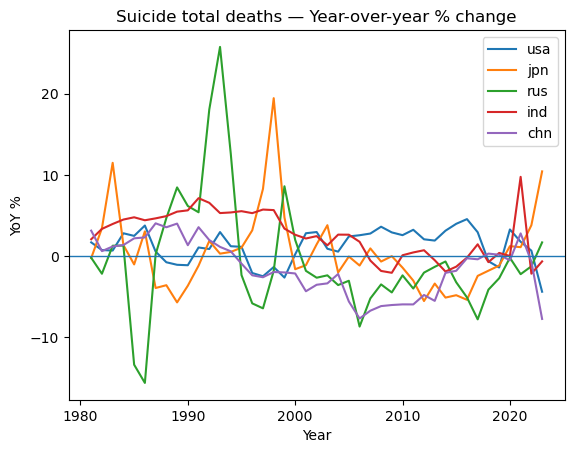

In [230]:
import matplotlib.pyplot as plt

def plot_suicides_yoy(geos=("usa","jpn","rus","ind","chn"), start_year=None, end_year=None):
    df = suicides_yoy_percent(geos=geos, start_year=start_year, end_year=end_year)

    plt.figure()
    for g in geos:
        d = df[df["geo"] == g].dropna(subset=["yoy_pct"])
        if not d.empty:
            plt.plot(d["time"], d["yoy_pct"], label=g)

    plt.axhline(0, linewidth=1)
    plt.title("Suicide total deaths — Year-over-year % change")
    plt.xlabel("Year")
    plt.ylabel("YoY %")
    plt.legend()
    plt.show()

plot_suicides_yoy(geos=("usa","jpn","rus","ind","chn"))


In [231]:
def yoy_summary(geos=("usa","jpn","rus","ind","chn"), start_year=None, end_year=None):
    df = suicides_yoy_percent(geos=geos, start_year=start_year, end_year=end_year)

    out = (df.dropna(subset=["yoy_pct"])
             .groupby("geo")
             .agg(
                 years=("time", "count"),
                 mean_yoy_pct=("yoy_pct", "mean"),
                 median_yoy_pct=("yoy_pct", "median"),
                 min_yoy_pct=("yoy_pct", "min"),
                 max_yoy_pct=("yoy_pct", "max"),
             )
             .sort_values("mean_yoy_pct", ascending=False)
          )
    return out

yoy_summary(geos=("usa","jpn","rus","ind","chn"))


years  mean_yoy_pct  median_yoy_pct  min_yoy_pct  max_yoy_pct
geo                                                               
ind     43      2.559478        2.621560    -2.176520     9.758562
usa     43      1.246713        1.681721    -4.398953     4.548668
jpn     43      0.490946       -0.254965    -5.712892    19.453002
rus     43     -0.564427       -2.184305   -15.636724    25.768986
chn     43     -1.382065       -0.939657    -7.751580     4.030530

In [232]:
import numpy as np

def cagr_by_country(geos=("usa","jpn","rus","ind","chn"), start_year=None, end_year=None):
    df = load("suicide_total_deaths").copy()
    df = df[df["geo"].isin(geos)].dropna(subset=["time", "value"])
    df = df.sort_values(["geo", "time"])

    if start_year is None:
        start_year = int(df["time"].min())
    if end_year is None:
        end_year = int(df["time"].max())

    df = df[(df["time"] >= start_year) & (df["time"] <= end_year)]

    rows = []
    for g, d in df.groupby("geo"):
        d = d.sort_values("time")
        start = d.loc[d["time"] == d["time"].min(), "value"].iloc[0]
        end = d.loc[d["time"] == d["time"].max(), "value"].iloc[0]
        n_years = int(d["time"].max() - d["time"].min())

        if n_years <= 0 or start <= 0 or end <= 0:
            cagr = np.nan
        else:
            cagr = (end / start) ** (1 / n_years) - 1

        rows.append({
            "geo": g,
            "start_year": int(d["time"].min()),
            "end_year": int(d["time"].max()),
            "start_value": float(start),
            "end_value": float(end),
            "cagr_pct_per_year": float(cagr * 100) if pd.notna(cagr) else np.nan
        })

    return pd.DataFrame(rows).sort_values("cagr_pct_per_year", ascending=False)

cagr_by_country(geos=("usa","jpn","rus","ind","chn"), start_year=2000, end_year=2021)


geo  start_year  end_year  start_value  end_value  cagr_pct_per_year
4  usa        2000      2021     32944.61   53263.22           2.314075
1  ind        2000      2021    175497.03  205876.34           0.763152
2  jpn        2000      2021     32018.98   23336.92          -1.494868
0  chn        2000      2021    213802.70  104197.71          -3.364772
3  rus        2000      2021     74617.67   35954.46          -3.417036

In [233]:
def top_spikes(geos=("usa","jpn","rus","ind","chn"), top_n=5):
    df = suicides_yoy_percent(geos=geos).dropna(subset=["yoy_pct"])
    return (df.sort_values("yoy_pct", ascending=False)
              .groupby("geo")
              .head(top_n)[["geo","time","value","yoy_pct"]])

top_spikes(geos=("usa","jpn","rus","ind","chn"), top_n=5)


geo  time      value    yoy_pct
6789  rus  1993   70831.81  25.768986
4022  jpn  1998   31068.40  19.453002
6788  rus  1992   56318.98  18.065502
6790  rus  1994   79769.86  12.618695
4007  jpn  1983   26127.89  11.485895
4047  jpn  2023   26749.11  10.431569
3649  ind  2021  205876.34   9.758562
6795  rus  1999   73164.15   8.595686
6785  rus  1989   42632.39   8.457286
4021  jpn  1997   26008.89   8.272929
3619  ind  1991  112735.93   7.129582
3620  ind  1992  120128.33   6.557271
3625  ind  1997  156562.48   5.727688
3626  ind  1998  165426.09   5.661388
4023  jpn  1999   32547.72   4.761494
8484  usa  2016   50267.93   4.548668
1503  chn  1987  206096.89   4.030530
1505  chn  1989  221933.00   3.996343
8483  usa  2015   48080.89   3.969989
8454  usa  1986   34213.15   3.758244
8476  usa  2008   39567.51   3.613313
1507  chn  1991  232886.63   3.554060
1504  chn  1988  213404.62   3.545774
8488  usa  2020   52343.17   3.275392
1497  chn  1981  183713.26   3.128816

In [234]:
import pandas as pd

def world_suicide_totals():
    df = load("suicide_total_deaths").copy()
    df = df.dropna(subset=["time", "value"])

    world = (
        df.groupby("time", as_index=False)["value"]
          .sum()
          .rename(columns={"value": "world_suicides"})
          .sort_values("time")
          .reset_index(drop=True)
    )

    return world

world = world_suicide_totals()
world.head()


time  world_suicides
0  1980       553077.44
1  1981       563689.86
2  1982       571673.10
3  1983       585912.71
4  1984       597572.17

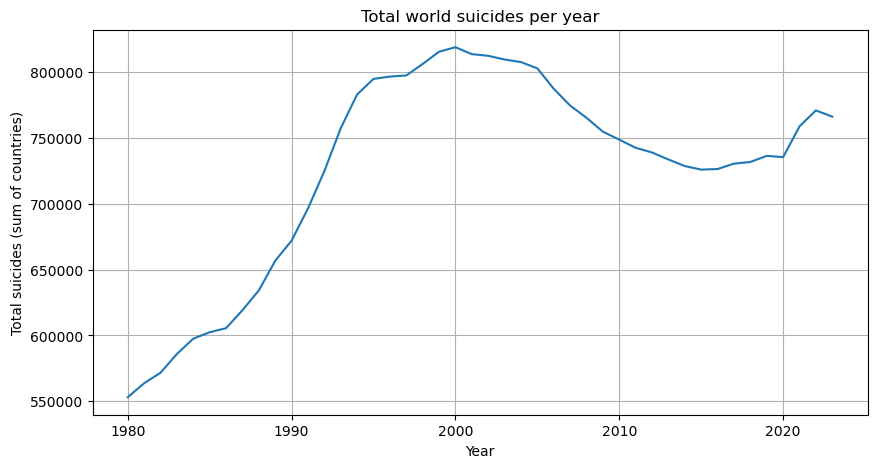

In [235]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(world["time"], world["world_suicides"])
plt.title("Total world suicides per year")
plt.xlabel("Year")
plt.ylabel("Total suicides (sum of countries)")
plt.grid(True)
plt.show()


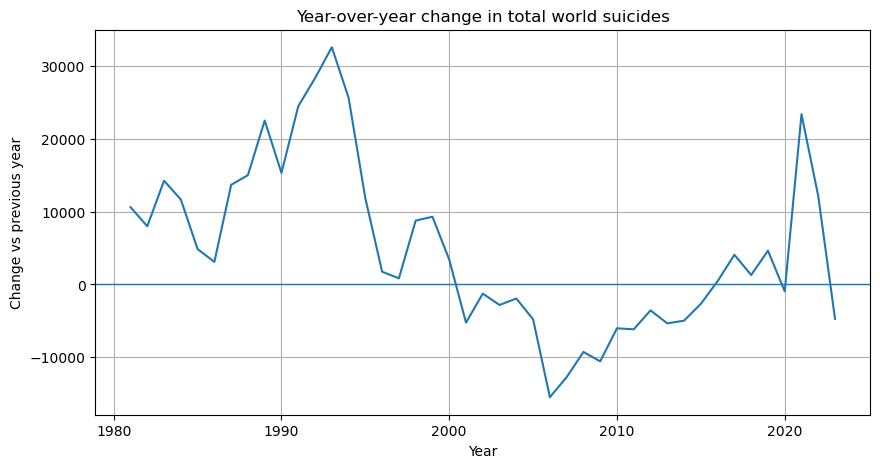

In [236]:
world["yoy_change"] = world["world_suicides"].diff()

plt.figure(figsize=(10, 5))
plt.plot(world["time"], world["yoy_change"])
plt.axhline(0, linewidth=1)
plt.title("Year-over-year change in total world suicides")
plt.xlabel("Year")
plt.ylabel("Change vs previous year")
plt.grid(True)
plt.show()


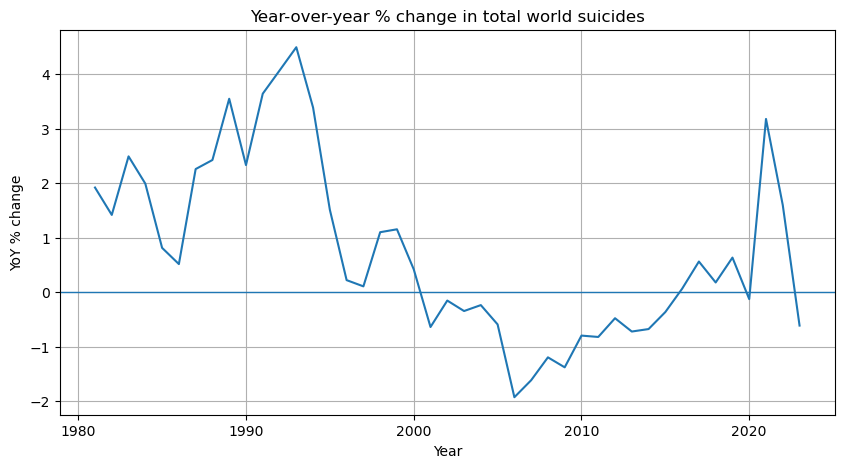

In [237]:
world["yoy_pct_change"] = world["world_suicides"].pct_change() * 100

plt.figure(figsize=(10, 5))
plt.plot(world["time"], world["yoy_pct_change"])
plt.axhline(0, linewidth=1)
plt.title("Year-over-year % change in total world suicides")
plt.xlabel("Year")
plt.ylabel("YoY % change")
plt.grid(True)
plt.show()


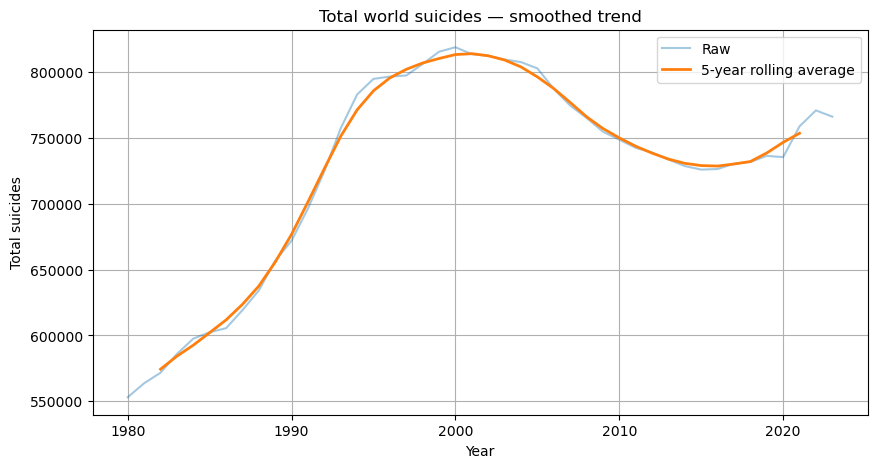

In [238]:
world["rolling_5yr_avg"] = world["world_suicides"].rolling(5, center=True).mean()

plt.figure(figsize=(10, 5))
plt.plot(world["time"], world["world_suicides"], alpha=0.4, label="Raw")
plt.plot(world["time"], world["rolling_5yr_avg"], linewidth=2, label="5-year rolling average")
plt.title("Total world suicides — smoothed trend")
plt.xlabel("Year")
plt.ylabel("Total suicides")
plt.legend()
plt.grid(True)
plt.show()


In [239]:
start_year = int(world["time"].min())
end_year = int(world["time"].max())

start_val = world.loc[world["time"] == start_year, "world_suicides"].iloc[0]
end_val = world.loc[world["time"] == end_year, "world_suicides"].iloc[0]
n_years = end_year - start_year

cagr = (end_val / start_val) ** (1 / n_years) - 1

print(f"Period: {start_year}–{end_year}")
print(f"Start total: {start_val:,.0f}")
print(f"End total:   {end_val:,.0f}")
print(f"Average yearly change (CAGR): {cagr*100:.2f}%")


Period: 1980–2023
Start total: 553,077
End total:   766,178
Average yearly change (CAGR): 0.76%
